# Convert Data

Need to convert the test data to be vitessce complient
Looks like I'll need about 5 or so files

## Files for running in python notebook
1. The CODEX images
    - in python, can ome-zarr or ome-tiff. Need conversion for either,
        - ome-zarr: https://github.com/vitessce/vitessce-python/blob/main/demos/codeluppi-2018/src/convert_to_ome_zarr.py
        - ome.tiff: https://pypi.org/project/tifffile/
    - as of now, multi-image only works for ome.tiff
2. Segmentation masks
    - this can be ome-tiff
    - Try as JSON? This can remember cell associations
3. Expression values
4. Metadata/annotations
5. Dimension reductions

## Files for React app
Based on https://github.com/vitessce/vitessce-python/tree/main/demos/codeluppi-2018
1. Segmentations
    - JSON file that just has polygon coordinates. dump from dictionary that has cell ID keys
2. Cell meta
    - csv
    - reductions, cell centroids, cell IDs as index
3. Expression
    - simple csv. Cell ID as row, marker as columns, fill with X
4. Images
    - ome.zarr

## Theming
### Neighborhood names
neighborhood_names_zeroindex <- c('0' = "HSC / Mature Myeloid",
                                  "1" = "Erythroid/Myeloid",
                                  "2" = "PC/Arteriolar",
                                  "3" = "Erythroid",
                                  "4" = "Arteriolar",
                                  "5" = "Erythroid",
                                  "6" = "Lymphoid",
                                  "7" = "Erythroid/Myeloid/Lymphoid",
                                  "8" = "Early Myeloid / Endosteal",
                                  "9" = "Myeloid/Lymphoid",
                                  "10" = "HSPC/Intermediate Myeloid",
                                  "11" = "Erythroid/Myeloid/Lymphoid",
                                  "12" = "Erythroid/Myeloid",
                                  "13" = "Early Myeloid / Arteriolar",
                                  "14" = "Peri-Arterolar Lymphoid")

nbs_cols = c("0"= "#A8D37F", "1" ="#51C8EB", "2" ="#AF7AB5", "3" ="#FBED24", "4" ="#FF0000", "5"="#FBED24","6"="#89919C", "7"="#BD7CB5", "8"="#4B409A", "9"="#FFA500","10"="#A15A26", "11"="#BD7CB5","12"="#BD7CB5", "13"="#51C8EB", "14"= "#4B409A")	

### Cell segmentation colors
cell_order <- c("HSC", "SPINK2+ HSPC", "HSPC", "GMP", "GMP/Myeloblast", "Early Myeloid Progenitor", "Intermediate Myeloid", "Mature Myeloid", "Monocytes", "Non-Classical Monocyte", "Macrophages", "pDC", "CLP", "Immature_B_Cell", "B-Cells", "CD4+ T-Cell", "CD8+ T-Cell", "Plasma Cells", "MEP/Early Erythroblast", "CD34+ CD61+", "Erythroblast", "Erythroid", "GATA1neg_Mks", "GATA1pos_Mks", "Adipo-MSC", "THY1+ MSC", "Adipocyte", "Endosteal", "AEC", "SEC", "VSMC", "Schwann Cells")

cal2_cols <- c("#CF9FFF", "#E7C7DC", "#CAA7DD", "#A8A2D2", "#B6D0E2", "#2874A6", "#5599C8", "#AEC6CF", "#6495ED", "#64b8ed", "#96C5D7", "#40B5AD", "#8FCACA", "#CCE2CB", "#63BA97", "#7DB954", "#64864A", "#019477", "#953553", "#A1045A", "#a15891", "#9C58A1", "#79127F", "#BF40BF", "#FFD580", "#FFC8A2", "#FDDA0D", "#F3B0C3", "#FFBF00", "#ff9d5c", "#DD3F4E", "#FF69B4")                                  

- Not sure if the image transpose is necessary...


In [1]:
import tifffile as tff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import anndata as ad
import pickle as pk
import scanpy as sc
from vitessce.data_utils import (
    multiplex_img_to_ome_zarr,
    optimize_adata,
    VAR_CHUNK_SIZE,
)
from vitessce import (
    VitessceConfig,
    Component as cm,
    CoordinationType as ct,
    AnnDataWrapper,
    OmeTiffWrapper,
    OmeZarrWrapper,
    CsvWrapper,
    MultiImageWrapper,
    AbstractWrapper,
)

from ome_zarr.format import FormatV02
from ome_zarr.writer import write_image
from ome_zarr.io import parse_url
import zarr
import xml.etree.ElementTree as ET 
import json

## Preparing full size H10 data

In [2]:
# channel_names = pd.read_table("/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/code/forQuPath/channelNames_cohort2.txt", header=None)
# channel_names = channel_names.iloc[:,0].to_list()

In [2]:
img = tff.TiffFile("/mnt/isilon/tan_lab_imaging/FUSION/NBM/NBM27_H10_CITRATE_REIMAGE/H10/Scan1/H10_Scan1.qptiff")

In [3]:
img.series[0].__dict__.keys()

dict_keys(['index', '_pages', 'levels', 'shape', 'axes', 'dtype', 'kind', 'name', 'transform', 'keyframe', 'parent', '_len'])

In [4]:
root = ET.fromstring(img.pages[0].description)

In [5]:
for s in root.findall('ScanProfile'):
    s_dict = json.loads(s.text)
    s_dict = s_dict['experimentDescription']['wells']

In [6]:
markers = ['DAPI']
for w in s_dict:
    for w_ in w['items']:
        mname = w_['markerName']
        if mname != '--' and mname not in markers:
            markers.append(mname)
len(markers)


54

In [12]:
img_dat = img.series[0].asarray()
img_dat = img_dat.astype(np.dtype("<u2"))
# img_dat = np.transpose(img_dat, axes=(0, 2, 1))

In [101]:
img_dat.shape

(54, 24480, 16320)

In [13]:
img_dat = np.expand_dims(img_dat, axis=1)
img_dat = np.expand_dims(img_dat, axis=0)
img_dat.shape

(1, 54, 1, 24480, 16320)

In [107]:
# # trim it down to...
moi = ['DAPI', 'VIM', 'NAKATPASE', 'CD45']
marker_i = [np.where(np.array(markers) == m) for m in moi]
marker_i = np.array(marker_i).flatten()

In [108]:
marker_i

array([ 0,  9, 42, 14])

In [109]:
img_dat_smaller = img_dat[:,marker_i,:,:,:]
img_dat_smaller.shape

(1, 4, 1, 24480, 16320)

In [27]:
# masks = tff.TiffFile("../data/test/bitmask_small.tiff")
# masks_dat = masks.series[0].asarray()
# masks_dat = masks_dat.astype(np.dtype("<u2"))
# masks_dat = np.transpose(masks_dat, axes=(1, 0))

In [31]:
# masks_dat.shape

(2000, 2000)

In [9]:
# img_dat_smaller.shape
# img_dat_smaller = np.expand_dims(img_dat_smaller, axis=1)
# img_dat_smaller = np.expand_dims(img_dat_smaller, axis=0)
# img_dat_smaller.shape

(1, 4, 1, 9504, 10031)

### Making ome-tiff

In [36]:
# CODEX data
subresolutions = 1
pixelsize = 0.29  # micrometer, just using what was in example, probably wrong
with tff.TiffWriter('../data/test/converted/codex.ome.tif', ome=True) as tif:
    metadata={
        'axes': 'CYX',
        'Channel': {'Name': channel_names},
    }
    # options = dict(
    #     photometric='minisblack',
    #     tile=(128, 128),
    #     compression='jpeg',
    #     resolutionunit='CENTIMETER'
    # )
    tif.write(
        img_dat,
        # subifds=subresolutions,
        metadata=metadata,
    )

In [39]:
# Mask data
subresolutions = 1
pixelsize = 0.29  # micrometer, just using what was in example, probably wrong
with tff.TiffWriter('../data/test/converted/masks.ome.tif', ome=True) as tif:
    metadata={
        'axes': 'YX',
    }
    options = dict(
        photometric='minisblack',
        # tile=(128, 128),
        # compression='jpeg',
        # resolutionunit='CENTIMETER'
    )
    tif.write(
        masks_dat,
        # subifds=subresolutions,
        metadata=metadata,
        **options
    )

In [ ]:
# Mask csv
# see "Make_small_data" notebook

### Making ome-zarr
code from https://github.com/vitessce/vitessce-python/blob/main/demos/codeluppi-2018/src/convert_to_ome_zarr.py

In [ ]:
# # for channel_i, channel_name in enumerate(channel_names):
# #     img_arr[channel_i, :, :] = img_dat[channel_i]

# multiplex_img_to_ome_zarr(
#     img_dat,
#     markers,
#     "../data/test/converted/codex_img.ome.zarr",
#     img_name="Image",
#     chunks=(1, 512, 512),
#     axes="tczyx",
# )

In [8]:
img_dat_smaller.shape

(4, 9504, 10031)

In [11]:
# making an even smaller image file
multiplex_img_to_ome_zarr(
    img_dat_smaller,
    markers,
    "../data/test/converted/HVCD1_wrapper.ome.zarr",
    img_name="HVCD1_reg1",
    chunks=(1, 512, 512),
    axes="cyx",
)

### Making OME-NGFF (zarr)

In [25]:
path = "../data/H10/H10_ngff_image.zarr"
size_xy = 512

In [26]:
store = parse_url(path, mode="w").store
root = zarr.group(store=store)

In [14]:
markers

['DAPI',
 'CD19',
 'CD4',
 'ASMA',
 'CD44',
 'CD271',
 'CD71',
 'CD90',
 'CD68',
 'VIM',
 'SPINK2',
 'CD45RA',
 'CD117',
 'FOXC1',
 'CD45',
 'CD61',
 'CD8',
 'CD11C',
 'CD49F',
 'VECAD',
 'ADIPOQ',
 'CD15',
 'CD123',
 'CD14',
 'CD138',
 'PLP1',
 'HLA-DR',
 'CD11B',
 'CD34',
 'CD10',
 'CD79A',
 'PAX5',
 'TGFB1',
 'MastCellTryptase',
 'VCAM1',
 'CD146',
 'Ki67',
 'CD3e',
 'CD33',
 'GATA1',
 'CD56',
 'CXCL12',
 'NAKATPASE',
 'BCL2',
 'GYPC',
 'HIF1A',
 'MPO',
 'OXPHOS',
 'CD38',
 'CD141',
 'BCAT',
 'PDPN',
 'CD163',
 'CXCR4']

In [27]:
# shit...I think i need to list every channel...
root.attrs["omero"] = {
    "name": "H10",
    "version": "0.3",
    "rdefs" : {},
    "channels": [{
        "color": "FFFFFF",
        "window": {"start": 0, "end": 240},
        "label": "DAPI",
        "active": True,
    },
    {
        "color": "9700FF",
        "window": {"start": 0, "end": 240},
        "label": "CD19",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD4",
        "active": True,
    },
    {
        "color": "FF0000",
        "window": {"start": 0, "end": 240},
        "label": "ASMA",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD44",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD271",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD71",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD90",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD68",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "VIM",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "SPINK2",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD45RA",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD117",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "FOXC1",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD45",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD61",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD8",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD11C",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD49F",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "VECAD",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "ADIPOQ",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD15",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD123",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD14",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD138",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "PLP1",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "HLA-DR",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD11B",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD34",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD10",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD79A",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "PAX5",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "TGFB1",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "MastCellTryptase",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "VCAM1",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD146",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "Ki67",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD3e",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD33",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "GATA1",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD56",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CXCL12",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "NAKATPASE",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "BCL2",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "GYPC",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "HIF1A",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "MPO",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "OXPHOS",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD38",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD141",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "BCAT",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "PDPN",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CD163",
        "active": True,
    },
    {
        "color": "FFDE00",
        "window": {"start": 0, "end": 240},
        "label": "CXCR4",
        "active": True,
    }]
}

In [28]:
write_image(image=img_dat, 
            group=root, 
            axes="tczyx",
            storage_options=dict(chunks=(1, size_xy, size_xy)))

## Preparing the adata

Something strange happened to the expression values. Need to use the "SCTC-VP-15/outs/simple_h5ad/..." values.

Looks like most of the cells are still there. 
**! need to check for regions were tiles were discarded !**
- maybe match on coordinates?

Motif names:
neighborhood_names_zeroindex <- c('0' = "HSC / Mature Myeloid",
                                  "1" = "Erythroid/Myeloid",
                                  "2" = "PC/Arteriolar",
                                  "3" = "Erythroid",
                                  "4" = "Arteriolar",
                                  "5" = "Erythroid",
                                  "6" = "Lymphoid",
                                  "7" = "Erythroid/Myeloid/Lymphoid",
                                  "8" = "Early Myeloid / Endosteal",
                                  "9" = "Myeloid/Lymphoid",
                                  "10" = "HSPC/Intermediate Myeloid",
                                  "11" = "Erythroid/Myeloid/Lymphoid",
                                  "12" = "Erythroid/Myeloid",
                                  "13" = "Early Myeloid / Arteriolar",
                                  "14" = "Peri-Arterolar Lymphoid")


### as zarr

In [18]:
adata = ad.read_h5ad("../data/H10/H10_processed.h5ad")
adata

AnnData object with n_obs × n_vars = 234104 × 49
    obs: 'orig.ident', 'nCount_CODEX', 'nFeature_CODEX', 'CellID', 'Size', 'x.coord', 'y.coord', 'DAPI', 'ADIPOQ', 'Ki67', 'CD56', 'NAKATPASE', 'RowSum', 'CODEX_snn_res.1.5', 'seurat_clusters', 'integrated_snn_res.0.5', 'cluster_anno_l1', 'cluster_anno_l2', 'cluster_anno_coarse'
    var: 'features', 'CODEX_features'
    obsm: 'X_UMAP_dim30', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'CODEX'

In [4]:
adata.obs.head()

,orig.ident,nCount_CODEX,nFeature_CODEX,CellID,Size,x.coord,y.coord,DAPI,ADIPOQ,Ki67,CD56,NAKATPASE,RowSum,CODEX_snn_res.1.5,seurat_clusters,integrated_snn_res.0.5,cluster_anno_l1,cluster_anno_l2,cluster_anno_coarse
2,SB67_NBM27_H10_CODEX_Mesmer,439.691057,49,2.0,123.0,13004.252033,104.243902,40.430894,21.211382,18.707317,21.666667,20.788618,522.065041,14,4,18,Erythroid,Artifact,Artifact
4,SB67_NBM27_H10_CODEX_Mesmer,621.033058,49,4.0,121.0,12980.925620,136.413223,24.685950,15.603306,2.132231,16.983471,18.975207,674.727273,14,4,18,Erythroid,Artifact,Artifact
5,SB67_NBM27_H10_CODEX_Mesmer,753.661972,49,5.0,71.0,12935.408451,153.746479,20.971831,12.225352,3.197183,10.323944,23.845070,803.253521,17,14,6,Megakaryocyte,Undetermined,Artifact
7,SB67_NBM27_H10_CODEX_Mesmer,500.769231,49,7.0,65.0,12875.461538,170.600000,27.000000,15.600000,2.507692,14.415385,18.276923,551.569231,15,4,18,Erythroid,Early Myeloid Progenitor,Myeloid
8,SB67_NBM27_H10_CODEX_Mesmer,518.670588,49,8.0,170.0,12922.470588,173.664706,36.611765,17.223529,1.964706,17.229412,18.976471,574.064706,14,4,18,Erythroid,Artifact,Artifact


In [24]:
adata.obsm['centroids'] = adata.obs.loc[:,['x.coord','y.coord']].to_numpy()

In [6]:
motif_anno = pd.read_csv("/mnt/isilon/tan_lab_imaging/Analysis/bandyopads/NBM_CODEX_Atlas/Combined_Analysis/Seurat/Neighborhood_Analysis_Step4/output/neighborhood.csv")
keep = motif_anno['orig.ident'].apply(lambda x: "H10" in x)
motif_anno = motif_anno.loc[keep,:]
motif_anno['CellID'] = motif_anno['CellID'].astype(int).astype(str)
motif_anno.set_index(keys="CellID", inplace=True)
motif_anno.head()

,Unnamed: 0.1,Unnamed: 0,orig.ident,nCount_CODEX,nFeature_CODEX,Size,x.coord,y.coord,DAPI,Metadata_CD19,...,Plasma Cells,SEC,SPINK2+ HSPC,Schwann Cells,THY1+ MSC,VSMC,pDC,neighborhood10,neighborhood20,neighborhood5
CellID,,,,,,,,,,,,,,,,,,,,,
7,0,4_1,SB67_NBM27_H10_CODEX_Mesmer,500.769231,49,65,12875.461538,170.600000,27.000000,7.030769,...,0,0,0,0,0,0,0,0,9,9
9,1,6_1,SB67_NBM27_H10_CODEX_Mesmer,663.769231,49,195,12903.358974,174.400000,51.179487,14.471795,...,0,0,0,0,0,0,0,0,9,9
11,2,8_1,SB67_NBM27_H10_CODEX_Mesmer,518.621908,49,283,13101.738516,186.279152,41.427562,7.692580,...,0,0,0,0,0,0,0,8,13,13
14,3,11_1,SB67_NBM27_H10_CODEX_Mesmer,489.111765,49,170,10516.105882,197.447059,30.400000,9.117647,...,0,0,0,0,0,0,0,10,2,2
15,4,12_1,SB67_NBM27_H10_CODEX_Mesmer,408.734375,49,128,12844.046875,198.773438,29.382812,8.164062,...,0,0,0,0,0,0,0,0,0,0


In [9]:
adata.obs = adata.obs.merge(motif_anno['neighborhood10'], how='left', left_index=True, right_index=True)

In [26]:
adata.obs.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 234104 entries, 2 to 238920
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   orig.ident              234104 non-null  object 
 1   nCount_CODEX            234104 non-null  float64
 2   nFeature_CODEX          234104 non-null  int32  
 3   CellID                  234104 non-null  float64
 4   Size                    234104 non-null  float64
 5   x.coord                 234104 non-null  float64
 6   y.coord                 234104 non-null  float64
 7   DAPI                    234104 non-null  float64
 8   ADIPOQ                  234104 non-null  float64
 9   Ki67                    234104 non-null  float64
 10  CD56                    234104 non-null  float64
 11  NAKATPASE               234104 non-null  float64
 12  RowSum                  234104 non-null  float64
 13  CODEX_snn_res.1.5       234104 non-null  object 
 14  seurat_clusters         2

In [29]:
zarr_filepath = "../data/H10/H10_adata.zarr"

In [14]:
adata_out = optimize_adata(
    adata,
    obs_cols=["cluster_anno_l2","neighborhood10"],
    obsm_keys=["X_UMAP_dim30", "centroids"],
    optimize_X=True,
)
adata_out.write_zarr(zarr_filepath, chunks=[adata_out.shape[0], VAR_CHUNK_SIZE])

In [24]:
adata = ad.read_zarr(zarr_filepath)
adata

AnnData object with n_obs × n_vars = 234104 × 49
    obs: 'cluster_anno_l2', 'neighborhood10'
    var: 'features', 'CODEX_features'
    obsm: 'X_UMAP_dim30', 'centroids'
    varm: 'PCs'
    layers: 'CODEX'

In [6]:
adata.obs.neighborhood10.unique()

array([nan,  0.,  8., 10., 13.,  4.,  1.,  9., 12., 11.,  3.,  7.,  2.,
        5.,  6., 14.])

In [25]:
motif_names = {0: "HSC / Mature Myeloid",
               1 : "Erythroid/Myeloid",
               2 : "PC/Arteriolar",
               3 : "Erythroid",
               4 : "Arteriolar",
               5 : "Erythroid",
               6 : "Lymphoid",
               7 : "Erythroid/Myeloid/Lymphoid",
               8 : "Early Myeloid / Endosteal",
               9 : "Myeloid/Lymphoid",
               10 : "HSPC/Intermediate Myeloid",
               11 : "Erythroid/Myeloid/Lymphoid",
               12 : "Erythroid/Myeloid",
               13 : "Early Myeloid / Arteriolar",
               14 : "Peri-Arterolar Lymphoid"}

In [26]:
adata.obs['motif_names'] = "unknown"
adata.obs.loc[~adata.obs.neighborhood10.isna(),"motif_names"] = adata.obs.neighborhood10[~adata.obs.neighborhood10.isna()].apply(lambda x: motif_names[x])

In [27]:
adata.obs["motif_names"].value_counts()

Erythroid/Myeloid             43648
Erythroid/Myeloid/Lymphoid    37117
HSC / Mature Myeloid          33538
Erythroid                     33007
unknown                       24795
Myeloid/Lymphoid              12986
HSPC/Intermediate Myeloid     11183
Early Myeloid / Arteriolar    10193
Lymphoid                       9533
Early Myeloid / Endosteal      8425
PC/Arteriolar                  4747
Arteriolar                     2766
Peri-Arterolar Lymphoid        2166
Name: motif_names, dtype: int64

In [30]:
adata_out = optimize_adata(
    adata,
    obs_cols=["cluster_anno_l2","neighborhood10","motif_names"],
    obsm_keys=["X_UMAP_dim30", "centroids"],
    optimize_X=True,
)
adata_out.write_zarr(zarr_filepath, chunks=[adata_out.shape[0], VAR_CHUNK_SIZE])

### as CSVs

In [28]:
# making a csv output
cells_df = adata_small.obs[["Unnamed: 0", "Absolute.Y", "Absolute.X", "new_pheno", "motif"]]
cells_df["Unnamed: 0"] = cells_df["Unnamed: 0"].astype(int)
cells_df.set_index("Unnamed: 0", inplace=True)
cells_df.index = cells_df.index.rename("cell_id")
cells_df.tail()

/tmp/ipykernel_93097/2192715062.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cells_df["Unnamed: 0"] = cells_df["Unnamed: 0"].astype(int)


,Absolute.Y,Absolute.X,new_pheno,motif
cell_id,,,,
41524,1833.046512,1941.697674,B_Cell,Motif_1
41525,1712.140741,1583.829630,B_Cell,Motif_1
41526,1859.259542,2002.175573,B_Cell,Motif_1
41527,1631.783784,1839.081081,B_Cell,Motif_1
41530,1581.342105,1512.394737,B_Cell,Motif_1


In [29]:
cells_df['UMAP_1'] = adata_small.obsm['X_umap'][:,0]
cells_df['UMAP_2'] = adata_small.obsm['X_umap'][:,1]

/tmp/ipykernel_93097/3242105401.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cells_df['UMAP_1'] = adata_small.obsm['X_umap'][:,0]
/tmp/ipykernel_93097/3242105401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cells_df['UMAP_2'] = adata_small.obsm['X_umap'][:,1]


In [31]:
matrix_df = pd.DataFrame(
    index=cells_df.index.values.tolist(),
    columns=adata_small.var.index.tolist(),
    data=adata_small.raw.X
)
matrix_df.index = matrix_df.index.rename("cell_id")

In [32]:
cells_df.to_csv("../data/test/converted/test_cells.csv", index=True)
matrix_df.to_csv("../data/test/converted/test_matrix.csv", index=True)

In [106]:
# ##This will take forever...
# segments = {}
# for i in tqdm(np.unique(masks_erode)):
#     if i == 0:
#         continue
#     poly = Mask(masks_erode==i).polygons()
#     segments[str(i)] = poly.points[0].tolist() # should hopefully only be 1 cell...

  0%|          | 262/233658 [01:30<22:18:51,  2.91it/s]


KeyboardInterrupt: 

## Making JSON mask

In [4]:
from tqdm import tqdm
from scipy import signal, ndimage
from imantics import Polygons, Mask
from skimage.draw import disk
import json
import scipy as sci
from itertools import compress

In [7]:
def erode_mask(masks):
    masks_erode = masks.copy()
    for i in tqdm(np.arange(1, masks.shape[0]-1)):
        for j in np.arange(1, masks.shape[1]-1):
            if (masks[i,j-1] != masks[i,j+1]) and (min((masks[i,j-1], masks[i,j+1])) != 0):
                masks_erode[i,j] = 0
            if (masks[i-1,j] != masks[i+1,j]) and (min((masks[i-1,j], masks[i+1,j])) != 0):
                masks_erode[i,j] = 0
    # # drop small cells
    # unique, counts = np.unique(masks_erode, return_counts=True)
    # c =np.asarray((unique, counts)).T
    # drop_index = c[np.where(c[:,1] < 50),0]
    # masks_erode[np.isin(masks_erode, drop_index[0])] = 0
    return masks_erode

In [6]:
mask = tff.TiffFile("/mnt/isilon/tan_lab_imaging/FUSION/NBM/NBM27_H10_CITRATE_REIMAGE/H10/Scan1/mesmer/Scan1_segmentation_cell.tif")

In [9]:
mask_dat = mask.pages[0].asarray()

In [10]:
masks_erode = erode_mask(mask_dat)
masks_erode = ndimage.binary_erosion(masks_erode, structure=np.ones((3,3)), iterations=1).astype(int) * masks_erode

100%|██████████| 24478/24478 [06:29<00:00, 62.81it/s]


In [19]:
# drop cells not in adata
good_cells = adata.obs.CellID.astype(int)
masks_keep = masks_erode.copy()
masks_keep[np.isin(masks_keep, good_cells, invert=True)] = 0
len(np.unique(masks_keep))

233739

In [ ]:
#########################################################################
#!!!! for some reason there are ~10k cells missing...how could that be??
#########################################################################

In [20]:
mask_binary = masks_keep > 0
mask_binary = mask_binary * 1

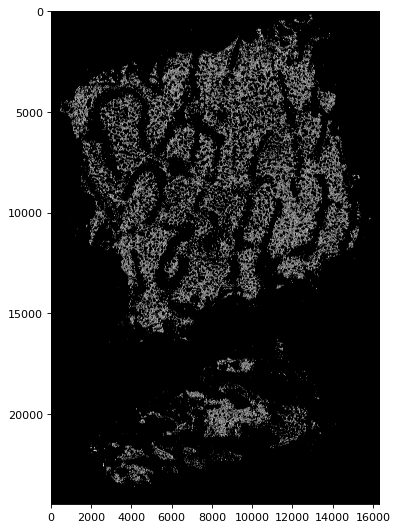

In [33]:
plt.figure(figsize=(12, 8), dpi=80)
# plt.imshow(dat >= global_thresh, cmap='gray')
plt.imshow(masks_erode > 0, cmap='gray')

In [21]:
poly = Mask(mask_binary).polygons()

In [34]:
len(poly.points)

224682

In [22]:
# make an array of segment centroids
seg_centroids = list(map(lambda x: np.apply_along_axis(np.mean,0,x), poly.points))
seg_centroids = np.vstack(seg_centroids)
seg_centroids.shape

(233818, 2)

In [25]:
# now matching up the centroids, query index should be second column of result
ref_tree = sci.spatial.cKDTree(adata.obsm['centroids'])
knn_res = ref_tree.query(seg_centroids, k=1)
seg_centroids.shape[0] - len(np.unique(knn_res[1]))
# shoot...looks like 67 cells got assigned to more than one segment
# for simplicity, going to drop "duplicated" segments
s = pd.Series(knn_res[1])
keep_seg = ~s.duplicated()
s = s[keep_seg]
seg_polygons = list(compress(poly.points,keep_seg.tolist()))
len(seg_polygons)

233738

In [31]:
s.iloc[3642]

230456

In [32]:
# assuming adata is prepared
segments = {}
for i in tqdm(range(len(seg_polygons))):
    cell_poly = seg_polygons[i].tolist()
    # coord = np.flip(coord)
    cell_i = s.iloc[i]
    segments[adata.obs.index.values[cell_i]] = cell_poly
    

100%|██████████| 233738/233738 [00:05<00:00, 44447.15it/s]


In [33]:
with open("../data/H10/segmentations.json", "w") as f:
    json.dump(segments, f)

## Preparing the bone images

In [34]:
import PIL
from PIL import Image

In [35]:
PIL.Image.MAX_IMAGE_PIXELS = 400000000

In [36]:
ext_img = Image.open("../data/H10/NBM27_H10_Scan1.qptiff - resolution_bone_annotation-labels (2).png")
ext_img = np.asarray(ext_img)

In [75]:
ext_img.shape

(24480, 16320)

In [37]:
# Bone image
subresolutions = 1
pixelsize = 0.29  # micrometer, just using what was in example, probably wrong
with tff.TiffWriter('../data/H10/bone.ome.tif', ome=True) as tif:
    metadata={
        'axes': 'YX',
    }
    tif.write(
        ext_img,
        # subifds=subresolutions,
        metadata=metadata,
    )

In [38]:
ext_img = Image.open("../data/H10/H10 macrophage-labels.png")
ext_img = np.asarray(ext_img)

In [39]:
ext_img.shape

(24480, 16320)

In [40]:
# Macrophage image
subresolutions = 1
pixelsize = 0.29  # micrometer, just using what was in example, probably wrong
with tff.TiffWriter('../data/H10/macrophage.ome.tif', ome=True) as tif:
    metadata={
        'axes': 'YX',
    }
    tif.write(
        ext_img,
        # subifds=subresolutions,
        metadata=metadata,
    )

## Testing the widget

In [7]:
# Option with ome-zarr
vc = VitessceConfig(schema_version="1.0.15", name='CODEX', description='Testing small slice of CODEX image')
dataset = vc.add_dataset(name='R1reg1').add_object(
    OmeZarrWrapper(img_path="/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/vitessce-gh-pages/data/test/converted/codex_img.ome.zarr")
)
spatial = vc.add_view(cm.SPATIAL, dataset=dataset)
status = vc.add_view(cm.STATUS, dataset=dataset)
lc = vc.add_view(cm.LAYER_CONTROLLER, dataset=dataset).set_props(disableChannelsIfRgbDetected=True)
vc.layout(spatial | lc / status);

In [44]:
# Option with ome.tiff
vc = VitessceConfig(schema_version="1.0.15", name='CODEX', description='Testing small slice of CODEX image')
dataset = vc.add_dataset(name='H10').add_object(
    MultiImageWrapper(
        image_wrappers=[
            # OmeZarrWrapper(img_path='../data/H10/H10_ngff_image.zarr/', name='Image'),
            OmeTiffWrapper(img_path='../data/H10/bone.ome.tif', name='Bone', is_bitmask=True),
            OmeTiffWrapper(img_path='../data/H10/macrophage.ome.tif', name='Macrophage'),
        ]
 )
)
# dataset = vc.add_dataset(name='H10').add_object(
#     OmeZarrWrapper(img_path='../data/H10/H10_ngff_image.zarr/', name='Image')
#  )

dataset = dataset.add_object(
    OmeZarrWrapper(img_path='../data/H10/H10_ngff_image.zarr/', name='Image')
 )

# making a UMAP
# dataset = vc.add_dataset(name="H10").add_object(AnnDataWrapper(
#     adata_path=zarr_filepath,
#     obs_set_paths=["obs/cluster_anno_l2", "obs/neighborhood10"],
#     obs_set_names=["phenotype", "motif"],
#     obs_embedding_paths=["obsm/X_UMAP_dim30", "obsm/centroids"],
#     obs_embedding_names=["UMAP", "centroids"],
#     obs_feature_matrix_path="X",
#     # obs_locations_path=["obsm/centroids"]
# ))
dataset = dataset.add_object(AnnDataWrapper(
    adata_path=zarr_filepath,
    obs_set_paths=["obs/cluster_anno_l2", "obs/neighborhood10"],
    obs_set_names=["phenotype", "motif"],
    obs_embedding_paths=["obsm/X_UMAP_dim30", "obsm/centroids"],
    obs_embedding_names=["UMAP", "centroids"],
    obs_feature_matrix_path="X",
    # obs_locations_path=["obsm/centroids"]
))

spatial = vc.add_view(cm.SPATIAL, dataset=dataset)
status = vc.add_view(cm.STATUS, dataset=dataset)
lc = vc.add_view(cm.LAYER_CONTROLLER, dataset=dataset)
umap = vc.add_view(cm.SCATTERPLOT, dataset=dataset, mapping="UMAP")
cell_sets = vc.add_view(cm.OBS_SETS, dataset=dataset)
genes = vc.add_view(cm.FEATURE_LIST, dataset=dataset)
vc.layout(spatial | umap | lc / cell_sets);

In [4]:
# # Option with ome.tiff and json segmentations
# dataset = vc.add_dataset(name='R1reg1').add_object(
#     MultiImageWrapper(
#         image_wrappers=[
#             OmeTiffWrapper(img_path='/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/vitessce-gh-pages/data/test/converted/codex.ome.tif', name='Image'),
#             OmeTiffWrapper(img_path='/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/vitessce-gh-pages/data/test/converted/masks.ome.tif', name='Mask', is_bitmask=True),
#         ]
#  )
# )


# spatial = vc.add_view(cm.SPATIAL, dataset=dataset)
# status = vc.add_view(cm.STATUS, dataset=dataset)
# lc = vc.add_view(cm.LAYER_CONTROLLER, dataset=dataset).set_props(disableChannelsIfRgbDetected=True)
# vc.layout(spatial | lc / status);

In [45]:
vw = vc.widget()
print(vw)

VitessceWidget(config={'version': '1.0.15', 'name': 'CODEX', 'description': 'Testing small slice of CODEX image', 'datasets': [{'uid': 'A', 'name': 'H10', 'files': [{'fileType': 'raster.json', 'options': {'schemaVersion': '0.0.2', 'usePhysicalSizeScaling': False, 'images': [{'name': 'Bone', 'type': 'ome-tiff', 'url': 'http://localhost:8001/A/0/4a387c3e-4b71-46f1-81e4-1d8097c23e8a', 'metadata': {'omeTiffOffsetsUrl': 'http://localhost:8001/A/0/817528d9-25d5-4556-a0e1-221d19865570', 'isBitmask': True}}, {'name': 'Macrophage', 'type': 'ome-tiff', 'url': 'http://localhost:8001/A/0/6aaf4bee-55d7-409b-b162-409e41b2e355', 'metadata': {'omeTiffOffsetsUrl': 'http://localhost:8001/A/0/5211fecc-2eb2-46b5-a32a-685ce36b1a06', 'isBitmask': False}}], 'renderLayers': ['Bone', 'Macrophage']}}, {'fileType': 'image.ome-zarr', 'url': 'http://localhost:8001/A/1/b57ce95a-a80e-4428-8301-b8c34b213875'}, {'fileType': 'anndata.zarr', 'url': 'http://localhost:8001/A/2/7d14e0fe-27c0-4e14-ba0f-813c1cd8354a', 'optio

In [92]:
vc.display()

In [90]:
vw

VitessceWidget(config={'version': '1.0.15', 'name': 'CODEX', 'description': 'Testing small slice of CODEX imag…

In [46]:
dat = ad.read_h5ad("/mnt/isilon/cscb/Projects/10x/robinsonj/SCTC-JR-75/processed/Robinson_dat.h5ad")
dat

/mnt/isilon/cscb/software/anaconda3/envs/vitessce/lib/python3.8/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 105614 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'aggr_id', 'exp.ident', 'pool', 'percent.mt', 'percent.rps', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.1', 'seurat_clusters', 'SCT_snn_res.0.5', 'cell_type_predicted', 'cell_type_coarse_predicted'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'

In [47]:
dat.__dict__['_raw'].__dict__['_var'] = dat.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})

In [48]:
dat.write("/mnt/isilon/cscb/Projects/10x/robinsonj/SCTC-JR-75/processed/Robinson_dat.h5ad")